In [1]:
import sqlite3

import numpy as np
import pandas as pd
from astropy.time import Time
import spiceypy as sp
from matplotlib import pyplot as plt
import matplotlib as mpl

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size': 12, 'mathtext.fontset': 'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

# Load SPICE kernels (meta file)
sp.furnsh('kernel_meta.txt')

# Get the G*M value for the Sun
_, GM_SUN = sp.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN[0]

# Compute the state vector of Jupiter in ECLIPJ2000 (Jupiter (599) is not
# available in the kernel, we use the barycentre (5))
KM2AU = sp.convrt(1, "km", "au")
RAD2DEG = sp.convrt(1, "radians", "degrees")
SEC2YR = sp.convrt(1, "seconds", "years")


def calc_a_jup(et):
    """ Compute the semi-major axis of Jupiter in au."""
    # Compute the state vector of Jupiter in ECLIPJ2000 (Jupiter (599) is not
    # available in the kernel, we use the barycentre (5))
    vec_jup, _lt = sp.spkgeo(5, et, ref='J2000', obs=10)
    elt_jup = sp.oscltx(vec_jup, et, GM_SUN)
    return elt_jup[9] * KM2AU


def tisserand_jup(a, e, i, a_jup):
    """ Compute the Tisserand parameter with respect to Jupiter.

    Parameters
    ----------
    a : float
        Semi-major axis [au]
    e : float
        Eccentricity
    i : float
        Inclination [rad]
    et : float
        Ephemeris time, TDB [s]
    """
    return a_jup/a + 2 * np.cos(i) * np.sqrt((1 - e**2)*a/a_jup)


# Set times
T1 = Time("2004-01-01", format='isot', scale='utc')
T2 = Time("2014-01-01", format='isot', scale='utc')
times_utc = Time(np.linspace(T1.jd, T2.jd, 1000), format='jd', scale='utc')
times_et = [sp.utc2et(_t) for _t in times_utc.utc.strftime('%Y-%m-%dT%H:%M:%S.%f')]
print(f"Times in UTC: {times_utc[0]} - {times_utc[-1]} (ET: {times_et[0]} - {times_et[-1]})")

# Extract information about the comet 67P
con = sqlite3.connect('../_databases/_comets/mpc_comets.db')
db_67p = pd.read_sql('SELECT NAME, PERIHELION_AU, SEMI_MAJOR_AXIS_AU, APHELION_AU, ECCENTRICITY, '
                     'INCLINATION_DEG, ARG_OF_PERIH_DEG, LONG_OF_ASC_NODE_DEG, EPOCH_ET FROM comets_main WHERE NAME LIKE "67P%"',
                     con)

db_67p = db_67p.rename(columns={'PERIHELION_AU': 'q', 'SEMI_MAJOR_AXIS_AU': 'a', 'INCLINATION_DEG': 'i',
                                'ECCENTRICITY': 'e', 'ARG_OF_PERIH_DEG': 'w', 'LONG_OF_ASC_NODE_DEG': 'om'})
db_67p['T'] = tisserand_jup(db_67p['a'], db_67p['e'], np.deg2rad(db_67p['i']), calc_a_jup(db_67p['EPOCH_ET'].iloc[0]))
print(db_67p)

# Compute the orbit of Jupiter
vec_jup_sol = np.array([sp.spkgeo(targ=5, et=_t, ref='ECLIPJ2000', obs=10)[0] for _t in times_et])
a_jup = [sp.oscltx(_vec, _t, GM_SUN)[9] for _vec, _t in zip(vec_jup_sol, times_et)]

# Compute the orbit of 67P using SPICE
NAIF_ID = 1000012
vec_67p_sol = np.array([sp.spkgeo(targ=NAIF_ID, et=_t, ref='ECLIPJ2000', obs=10)[0] for _t in times_et])
elt_67p = pd.DataFrame(
    [sp.oscltx(_vec, _t, GM_SUN) for _vec, _t in zip(vec_67p_sol, times_et)],
    columns=['q', 'e', 'i', 'om', 'w', 'M0', 'T0', 'mu', 'nu', 'a', 'per']
)

elt_67p['a_jup'] = a_jup
for c in ['q', 'a', 'a_jup']:
    elt_67p[c] *= KM2AU
elt_67p['T'] = tisserand_jup(elt_67p['a'], elt_67p['e'], elt_67p['i'], elt_67p['a_jup'])
elt_67p['d'] = np.linalg.norm(vec_jup_sol[:, :3] - vec_67p_sol[:, :3], axis=1) * KM2AU
for c in ['i', 'om', 'w', 'nu', 'M0']:
    elt_67p[c] *= RAD2DEG
elt_67p['per'] *= SEC2YR
elt_67p

Times in UTC: 2453005.5 - 2456658.5 (ET: 126187264.1839117 - 441806467.18392336)
                        NAME         q         a  APHELION_AU         e  \
0  67P/Churyumov-Gerasimenko  1.202134  3.455133     5.708132  0.652073   

        i        w       om      EPOCH_ET         T  
0  3.8868  21.8178  36.8291  6.890125e+08  2.739664  


,q,e,i,om,w,M0,T0,mu,nu,a,per,a_jup,T,d
0,1.290612,0.631757,7.124160,50.930690,11.406116,75.214526,1.261873e+08,1.327124e+11,142.795735,3.504787,6.561464,5.206516,2.747709,3.936493
1,1.290595,0.631759,7.124205,50.930514,11.405621,75.764766,1.265032e+08,1.327124e+11,143.086346,3.504759,6.561385,5.206520,2.747714,3.939590
2,1.290578,0.631761,7.124251,50.930341,11.405124,76.315024,1.268191e+08,1.327124e+11,143.374721,3.504731,6.561306,5.206524,2.747719,3.942576
3,1.290561,0.631763,7.124295,50.930172,11.404624,76.865295,1.271351e+08,1.327124e+11,143.660901,3.504703,6.561227,5.206527,2.747724,3.945453
4,1.290544,0.631765,7.124339,50.930008,11.404123,77.415579,1.274510e+08,1.327124e+11,143.944923,3.504675,6.561149,5.206531,2.747728,3.948221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.242888,0.641138,7.041927,50.162841,12.760075,267.701914,4.405427e+08,1.327124e+11,208.447495,3.463417,6.445631,5.207642,2.745865,9.796256
996,1.242890,0.641137,7.041896,50.162616,12.760488,268.260366,4.408587e+08,1.327124e+11,208.683462,3.463408,6.445606,5.207641,2.745870,9.783502
997,1.242893,0.641135,7.041864,50.162388,12.760897,268.818826,4.411746e+08,1.327124e+11,208.920814,3.463400,6.445582,5.207639,2.745874,9.770660
998,1.242896,0.641133,7.041832,50.162157,12.761302,269.377297,4.414905e+08,1.327124e+11,209.159573,3.463391,6.445558,5.207636,2.745878,9.757729


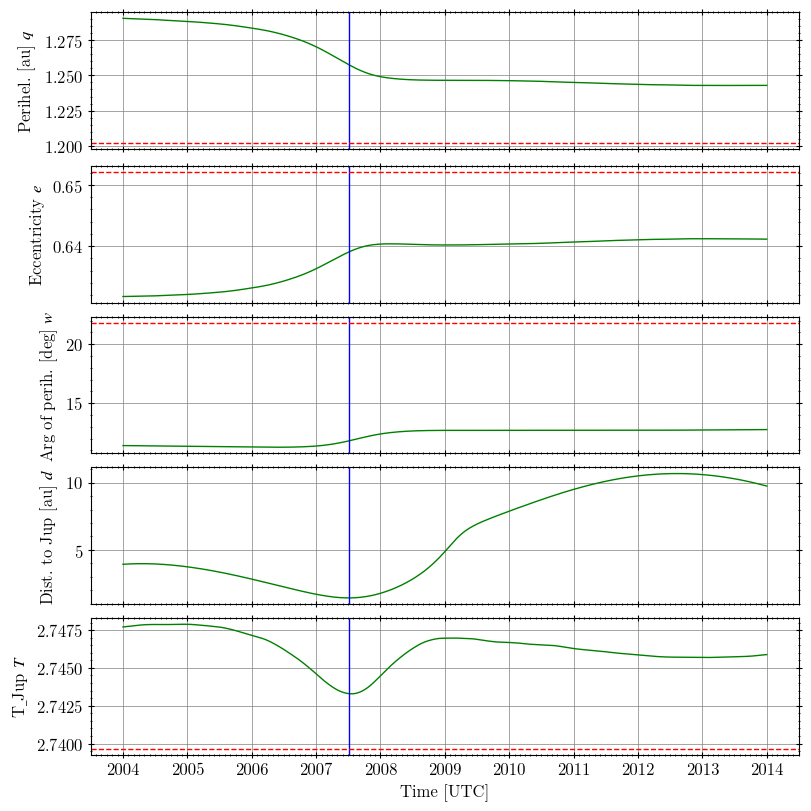

In [2]:
fig, axs = plt.subplot_mosaic("q\ne\nw\nd\nT", figsize=(8, 8), layout="constrained", gridspec_kw=None, sharex=True, sharey=False)

close_encounter = times_utc[np.argmin(elt_67p['d'])]

for yval, name in zip(["q", "e", "w", "d", "T"], ["Perihel. [au]", "Eccentricity", "Arg of perih. [deg]", "Dist. to Jup [au]", "T_Jup"]):
    _ax = axs[yval]
    _ax.plot(times_utc.plot_date, elt_67p[yval], "g-", label=yval, lw=1)
    _ax.set(
        ylabel=r"{} ${}$".format(name, yval),
    )
    _ax.axvline(close_encounter.plot_date, color="b", ls="-", lw=1)
    try:
        _ax.axhline(db_67p[yval].iloc[0], color="r", ls="--", lw=1)
    except KeyError:
        continue

axs["T"].set_xlabel("Time [UTC]")
axs["T"].xaxis.set_major_locator(mpl.dates.YearLocator())
axs["T"].xaxis.set_minor_locator(mpl.dates.MonthLocator())
axs["T"].xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))

plt.show();